# Time Series Data: Part 1

Many parts of this lecture were borrowed from:

* QuantEcon's lectures on time series analysis
* Time Series Analysis with Applications in R by Jonathan Cryer and Kung-Sik Chan

Any errors introduced by my interpretation of their excellent work are solely my own.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pandas_datareader import DataReader
from sklearn import linear_model

%matplotlib inline

## What is a Time Series?

The word time series is often conflated to interchangeably mean two things:

1. A sequence (over time) of observations of some variable. For example, the stock price of Microsoft from 1995 to 2021.
2. A joint probability distribution over a sequence of random variable $\{x_t\}$ (aka, a model). For example, $x_t = \varepsilon_t$ with $\varepsilon_t \sim_{\text{i.i.d}} N(0, 1)$


**Why do we care?**

One of the key differences between cross-sectional data and time series data is that there will be inherent intertemporal dependence in the observations.

This dependence helps us build models that allow us to

1. Predict future values of the time series data (forecasting)
2. Understand what the sequence of observations tell us about the current state (filtering)
3. Understand what the sequence of observations tell us about past observations (smoothing)

### Stochastic Processes

We call a sequence of random variables $\{Y_t\}_{t=-\infty}^{\infty}$ a stochastic process

As usual, we can compute means, covariances, and correlations:

* Mean: $\mu_t = E[Y_t]$
* Autocovariance: $\gamma_{t, s} = \text{Cov}(Y_t, Y_s)$
* Autocorrelation: $\rho_{t, s} = \frac{\gamma_{t, s}}{\sqrt{\gamma_{t, t}, \gamma_{s, s}}}$

**Example 1: White noise**

Let $Y_0 = 0$ and $Y_{t+1} = \sigma \varepsilon_t$ with $\varepsilon_t \sim N(0, 1)$, then:

Mean at $t=1$:

\begin{align*}
  E[Y_1] &= E[\sigma \varepsilon_1] \\
  &= 0
\end{align*}

Can you guess what the mean at $t=2$ is? How about $t=3$?

Autocovariance between $t=1$ and $t=3$:

\begin{align*}
  \text{Cov}(Y_1, Y_3) &= E[(Y_1 - \mu_1) (Y_3 - \mu_3)] \\
  &= E[Y_1 Y_3 - Y_1 \mu_3 - \mu_1 Y_3 + \mu_1 \mu_3] \\
  &= E[\sigma \varepsilon_1 \sigma \varepsilon_3] \\
  &= 0
\end{align*}


Autocorrelation between $t=1$ and $t=5$

\begin{align*}
  \text{Corr}(Y_1, Y_5) &= \frac{\gamma_{1, 5}}{\sqrt{\gamma_{1, 1} \gamma_{5, 5}}} \\
  &= 0
\end{align*}


**Example 2: Autoregressive process**

Let $Y_0 = 0$ and $Y_{t+1} = \rho Y_t + \sigma \varepsilon_t$ with $\varepsilon_t \sim N(0, 1)$, then:

Mean at $t=1$:

\begin{align*}
  E[Y_1] &= E[\rho Y_0 + \sigma \varepsilon_1] \\
  &= \rho Y_0 + \sigma E[\varepsilon_1] \\
  &= 0
\end{align*}

Can you guess what the mean at $t=2$ is? How about $t=3$?

Autocovariance between $t=1$ and $t=3$:

\begin{align*}
  \text{Cov}(Y_1, Y_3) &= E[(Y_1 - \mu_1) (Y_3 - \mu_3)] \\
  &= E[(\rho Y_0 + \sigma \varepsilon_1 - \mu_1) (\rho Y_2 + \sigma \varepsilon_3 - \mu_3)] \\
  &= E[(\rho Y_0 + \sigma \varepsilon_1) (\rho (\rho Y_1 + \sigma \varepsilon_2) + \sigma \varepsilon_3)] \\
  &= E[(\rho Y_0 + \sigma \varepsilon_1) (\rho (\rho (\rho Y_0 + \sigma \varepsilon_1) + \sigma \varepsilon_2) + \sigma \varepsilon_3)] \\
  &= E[\sigma \varepsilon_1 (\rho^2 \sigma \varepsilon_1 + \rho \sigma \varepsilon_2 + \sigma \varepsilon_3)] \\
  &= \rho^2 \sigma^2
\end{align*}

Generically for $1 \leq t \leq s$, the autocovariance will be given by $\rho^{s-t} \sigma^2$

Autocorrelation between $t=1$ and $t=5$

\begin{align*}
  \text{Corr}(Y_1, Y_5) &= \frac{\gamma_{1, 5}}{\sqrt{\gamma_{1, 1} \gamma_{5, 5}}} \\
  &= \frac{\rho^4 \sigma}{\sqrt{\sigma^2 \sigma^2}} \\
  &= \rho^4
\end{align*}

Generically for $1 \leq t \leq s$, the autocorrelation will be given by $\rho^{s-t}$

**Example 3: A random walk**

Let $Y_0 = 0$ and $Y_{t+1} = Y_{t} + \sigma \varepsilon_t$ with $\varepsilon_t \sim N(0, 1)$, then:

Mean at $t=1$:

\begin{align*}
  E[Y_1] &= E[Y_0 + \sigma \varepsilon_1] \\
  &= Y_0 + E[\sigma \varepsilon_1] \\
  &= 0
\end{align*}

Can you guess what the mean at $t=2$ is? How about $t=3$?

Autocovariance between $t=1$ and $t=3$:

\begin{align*}
  \text{Cov}(Y_1, Y_3) &= E[(Y_1 - \mu_1) (Y_3 - \mu_3)] \\
  &= E[Y_1 Y_3 - Y_1 \mu_3 - \mu_1 Y_3 + \mu_1 \mu_3] \\
  &= E[(Y_0 + \sigma \varepsilon_1) (Y_0 + \sigma \varepsilon_1 + \sigma \varepsilon_2 + \sigma \varepsilon_3)] \\
  &= E[\sigma^2 (\varepsilon_1 \varepsilon_1 + \varepsilon_1 \varepsilon_2 + \varepsilon_1 \varepsilon_3] \\
  &= \sigma^2
\end{align*}

Generically, $\text{Cov}(Y_t, Y_s)$ with $1 \leq t \leq s$ will result in a covariance of $t \sigma^2$

Autocorrelation between $t=1$ and $t=5$

\begin{align*}
  \text{Corr}(Y_1, Y_5) &= \frac{\gamma_{1, 5}}{\sqrt{\gamma_{1, 1} \gamma_{5, 5}}} \\
  &= \frac{\sigma^2}{\sqrt{\sigma^2 5 \sigma^2}} \\
  &= \sqrt{\frac{1}{5}}
\end{align*}

Generically, $\text{Corr}(Y_t, Y_s)$ with $1 \leq t \leq s$ will result in a correlation of $\sqrt{\frac{t}{s}}$

### Stationarity

In order to make statistical inferences about the structure of a stochastic process ("do time series analysis), we must assume stationarity

Why must we do this? If the stochastic process were not stationary then we would have a difficult time estimating the laws that govern the process because they would be changing over time...

**Strict stationarity**

A stochastic process, $\{Y_t\}$, is said to be stricly stationary if the joint distribution of $\{Y_{t_1}, Y_{t_2}, \cdots, Y_{t_n}\}$ is the same as $\{Y_{t_1 + k}, Y_{t_2 + k}, \cdots, Y_{t_n + k}\}$.

Do any of our examples satisfy strict stationarity?

**Weakly stationary**

A stochastic process, $\{Y_t\}$, is said to be weakly stationary if

1. The mean is constant over time and
2. $\gamma_{t-k, t} = \gamma{k, 0}$ for all time $t$ and lag $k$

Do any of our examples satisfy weak stationarity?

### Example Time Series

We will talk about whether each series is stationary

In [ ]:
def plot_timeseries(df):
    fig, ax = plt.subplots()
    
    df.plot(ax=ax)

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    return fig

In [ ]:
gdp = DataReader("GDP", "fred", 1975, 2021)

plot_timeseries(gdp);

In [ ]:
nasdaq = DataReader("NASDAQCOM", "fred", 2000, 2021).dropna()

plot_timeseries(nasdaq);

In [ ]:
dataurl = "https://raw.githubusercontent.com/plotly/datasets/master/monthly-milk-production-pounds.csv"
milk_data = pd.read_csv(
    dataurl
).rename(
    columns={
        "Monthly milk production (pounds per cow)": "milk_per_cow"
    }
)
milk_data["dt"] = pd.to_datetime(milk_data["Month"])
milk_data = milk_data.set_index("dt").loc[:, "milk_per_cow"]

plot_timeseries(milk_data);

In [ ]:
energy = pd.read_csv(
    "Native_Load_2020.csv",
    delimiter="\t"
)

for i in range(24):
    old, new = f"{i+1:02}:00", f"{i:02}:00"
    energy["HourEnding"] = energy["HourEnding"].str.replace(old, new)
energy["dt"] = pd.to_datetime(energy["HourEnding"])
energy["ercot"] = pd.to_numeric(energy["ERCOT"].str.replace(",", ""))

energy = energy.set_index("dt").loc[:, "ercot"]

In [ ]:
# Daily demand
plot_timeseries(energy.resample("D").sum());

In [ ]:
# Hourly demand
plot_timeseries(energy.loc["2020-06-01":"2020-07-01"]);

**Stationary violations**

Many time series datasets will violate stationarity in some way shape or form...

We typically think of a few types of violations:

1. Trends: Typically a longer term movement. Each of the graphs that we saw previously seemed to have a mean that increased over time (violating the constant mean assumption).
2. Seasonality: A shorter term fluctuation that occurs repeatedly. For example, in the milk example, milk production per cow seemed to peak between April and July and then dropped during the other months of the year (violating the constant mean assumption). This also occurs at various frequencies for energy data.
3. Structural changes:
  * Heteroskedasticity: There are times that the variance of the observations seems to increase/decrease. For example, in the Nasdaq example, there were times that the prices seemed more volatile (violating the constant variance/autocovariance assumption).
  * Structural breaks: There are times that the data may behave in a way that is at odds with any model capable of explaining other regions of the data. For example, any model that might have performed quite well on GDP prior to 2020, likely would have struggled with the rapid drop caused by COVID-19.

**Solutions?**

* Find a way to remove the violations from the data observations. For example, we might think about fluctuations around the long-term trend of GDP rather than model GDP directly.
* A richer model. We can always add additional bells and whistles to help us explain the data.

While the second can be lots of fun, the first is often a more straightforward way to deal with commonly encountered issues like trends and seasonal fluctuations.

## Transformations!

We now discuss some common transformations to the data that can help us deal with certain problems

**Differences**

Recall our random walk process:

$$Y_{t+1} = Y_{t} + \sigma \varepsilon_{t+1}$$

This stochastic process is not stationary (the variance increases over time), however, the difference of the process is stationary

$$Y_{t+1} - Y_{t} = \sigma \varepsilon_{t+1}$$

Let's try differencing our GDP data

Do we think it looks stationary now?

Probably not, especially with the increased volatility due to COVID at the end, but the difference procedure does seem to have at least removed the upward trend.

In [ ]:
plot_timeseries(gdp.diff());

Similar outcome for taking the differences of the Nasdaq series

In [ ]:
plot_timeseries(nasdaq.diff());

What about for the milk data? Hmmm, at first glance, maybe not

In [ ]:
plot_timeseries(milk_data.diff());

What if we take the difference from a year ago!?

Better. This looks like it could potentially be generated by a stationary process like an AR(1).

In [ ]:
plot_timeseries(milk_data.diff(12));

**Logs**

Another transformation that helps can be to take logs of the stochastic process

Doesn't seem to help much when applied directly to GDP or NASDAQ

In [ ]:
plot_timeseries(np.log(gdp));

In [ ]:
plot_timeseries(np.log(nasdaq));

Well... The issue with the differences was that after differencing, we still had non-constant variance. What if we do the log difference?

This seems to be a slight improvement but still evidence of time-varying volatility... This would be a case where to accurately model the data, we'd likely need a more complete model... Stay tuned!

In [ ]:
plot_timeseries(np.log(nasdaq).diff());

## Rolling Averages

One way that we can choose to find a trend is by averaging in creative ways:

* Rolling average: $\hat{\mu}_t = \sum_{\tau=0}^{k} Y_{t - \tau}$
* Exponential: $\hat{\mu}_t = \sum_{\tau=0}^{k} (1 - \alpha)^\tau Y_{t - \tau}$

Let's try these for the GDP data

In [ ]:
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(12, 6))

gdp.plot(ax=ax[0], legend=False)
ax[0].set_title("Original")

(gdp - gdp.rolling(4).mean()).plot(ax=ax[1], legend=False)
ax[1].set_title("Original - Rolling")

(gdp - gdp.ewm(4).mean()).plot(ax=ax[2], legend=False)
ax[2].set_title("Original - Exponential")


And for the Nasdaq data

In [ ]:
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(12, 6))

nasdaq.plot(ax=ax[0], legend=False)
ax[0].set_title("Original")

(nasdaq - nasdaq.rolling(4).mean()).plot(ax=ax[1], legend=False)
ax[1].set_title("Original - Rolling")

(nasdaq - nasdaq.ewm(4).mean()).plot(ax=ax[2], legend=False)
ax[2].set_title("Original - Exponential")


## Regression!

Another solution is to fit the trend and seasonal components using a regression

**Regression time trends**

One choice for fitting trends that we have is to fit a regression model of the following form:

$$Y_t = \alpha + \beta f(t)$$

where $f(t)$ is some function of time.

The most common choices for $f(t)$ are:

* $f(t) = t$
* $f(t) = \begin{bmatrix} t \\ t^2 \end{bmatrix}$

Linear time trend for GDP

In [ ]:
# Fit this to GDP data
ngdp = gdp.shape[0]
tvalues = np.arange(ngdp).reshape(-1, 1)
yvalues = gdp["GDP"].to_numpy()

lm = linear_model.LinearRegression(fit_intercept=True)
lm.fit(tvalues, yvalues)

fig, ax = plt.subplots()

ax.plot(gdp.index, gdp["GDP"])
ax.plot(gdp.index, lm.predict(tvalues))

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

Quadratic time trend for GDP

In [ ]:
tat2 = np.hstack([tvalues, tvalues**2])

lm = linear_model.LinearRegression(fit_intercept=True)
lm.fit(tat2, yvalues)

fig, ax = plt.subplots()

ax.plot(gdp.index, gdp["GDP"])
ax.plot(gdp.index, lm.predict(tat2))

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

Additionally, all of the things that we've talked about previously for regression can be applied here!

We can choose to use ridge regression, lasso regression, or elastic-net regression!

In [ ]:
nnasdaq = nasdaq.shape[0]
tvalues = np.arange(nnasdaq).reshape(-1, 1)
yvalues = nasdaq["NASDAQCOM"].to_numpy()

lasso = linear_model.Lasso(fit_intercept=True)
lasso.fit(tvalues, yvalues)

fig, ax = plt.subplots()

ax.plot(nasdaq.index, nasdaq["NASDAQCOM"])
ax.plot(nasdaq.index, lasso.predict(tvalues))

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

In [ ]:
tat2 = np.hstack([tvalues, tvalues**2])
ridge = linear_model.Ridge(alpha=50, fit_intercept=True)
ridge.fit(tat2, yvalues)

fig, ax = plt.subplots()

ax.plot(nasdaq.index, nasdaq["NASDAQCOM"])
ax.plot(nasdaq.index, ridge.predict(tat2))

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

In [ ]:
energyD = energy.resample("D").sum().to_frame()
nenergy = energyD.shape[0]
tvalues = (np.arange(nenergy)/50).reshape(-1, 1)
yvalues = energyD["ercot"].to_numpy()
tatn = np.hstack([tvalues, tvalues**2, tvalues**4, tvalues**7])

lasso = linear_model.Lasso(alpha=5, fit_intercept=True, max_iter=50_000)
lasso.fit(tatn, yvalues)

fig, ax = plt.subplots()

ax.plot(energyD.index, yvalues)
ax.plot(energyD.index, lasso.predict(tatn))

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

**Seasonal fixed effects**

Regression performs well for time trends -- In our case, we thought the quadratic trend lines for GDP and the Nasdaq were very compelling. We were slightly less convinced by the lines drawn through the daily energy data...

For data driven by more seasonal effects, we could instead use a fixed effect regression:

$$Y_t = \mu_t + X_t$$

where $X_t$ is some non-seasonal component with $E[X_t] = 0$ and $\mu_t$ is a component with a separate value for each "season".

This is often referred to as a "seasonal means model"

**Example**:

In the energy data, it seems like the mean energy usage increases around June and comes back down in October. A simple way to separate the data would be to have "summer" and "non-summer" seasons with separate means... Then

$$\mu_t = \begin{cases} \mu_{\text{summer}} \; \text{when month in [June, July, August, September]} \\ \mu_{\text{non-summer}} \; \text{otherwise} \end{cases}$$

In [ ]:
# Create seasonal components
energyD["month"] = energyD.index.month
energyD["summer"] = energyD["month"].apply(lambda x: 1 if (x >= 6 and x < 9) else 0)
energyD["non-summer"] = 1 - energyD["summer"]

X = energyD.loc[:, ["non-summer", "summer"]].to_numpy()
y = energyD.loc[:, "ercot"]

In [ ]:
lm = linear_model.LinearRegression(fit_intercept=False)
lm.fit(X, y)

We can see that this model actually performs reasonably well in terms of detrending the data.

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

ax[0].plot(energyD.index, energyD.loc[:, "ercot"])
ax[0].plot(energyD.index, lm.predict(X))

ax[1].plot(energyD.index, energyD.loc[:, "ercot"] - lm.predict(X))

for _ax in ax:
    _ax.spines["right"].set_visible(False)
    _ax.spines["top"].set_visible(False)

**Cosine trends**

The seasonal means model is a great model but, as we increase the number of groups in our data, the model will ignore the fact that we expect groups that are near each other temporally to behave similarly.

For example, if we instead had one mean per month rather than simply breaking the model into summer and non-summer, then, due to randomness in data realizations, the result could have had March and June being more similar than June and July... This approach also gives us "many" (not that many) free parameters and might result in us overfitting the data.

In some cases, cosine trends is a good solution. We stick with a similarly structured model,

$$Y_t = \mu_t + X_t$$

except now $\mu_t = \beta \cos(2 \pi f t + \Phi)$

Let's see an example of this function below:

Let $f = 1/12$ be the frequency of the oscillation -- We will see a complete oscillation every 12 periods which we'll interpret as monthly data.

We set other parameters to values that we "picked out of a hat".

We then plot this function for 24 months

In [ ]:
fig, ax = plt.subplots()

beta = 2.0
tvalues = np.arange(24)
f = 1/12
mu = beta * np.cos(2*np.pi*f*tvalues + np.pi/2)

ax.plot(tvalues, mu)

This seems promising -- We can cyclical fluctuations which will give us the same value for the same month of the year!

Not so easy to estimate this though... How do we get $\Phi$?

We want all of our coefficients outside of the $f(x)$ so that we can do regression.

Time to break out our trigonometry books (or just trust us...)!

\begin{align*}
  \mu_t &= \beta \cos(2 \pi f t + \Phi) \\
  &= \beta_1 \cos(2 \pi f t) + \beta_2 \sin(2 \pi f t)
\end{align*}

where $\beta \equiv \sqrt{\beta_1^2 + \beta_2^2}$ and $\Phi = \arctan(-\beta_2 / \beta_1)$

We can instead run the following (equivalent) regression:

$$\mu_t = \beta_0 + \beta_1 \cos(2 \pi f t) + \beta_2 \sin(2 \pi f t)$$

In [ ]:
f = 1/12
energyD["costerm"] = np.cos(2*f*np.pi*energyD["month"])
energyD["sinterm"] = np.sin(2*f*np.pi*energyD["month"])

X = np.hstack([
    energyD.loc[:, "costerm"].to_numpy().reshape(-1, 1),
    energyD.loc[:, "sinterm"].to_numpy().reshape(-1, 1),
])
y = energyD["ercot"]

lm = linear_model.LinearRegression(fit_intercept=True)
lm.fit(X, y)

fig, ax = plt.subplots(2, 1, figsize=(10, 8))

ax[0].plot(energyD.index, energyD.loc[:, "ercot"])
ax[0].plot(energyD.index, lm.predict(X))

ax[1].plot(energyD.index, energyD.loc[:, "ercot"] - lm.predict(X))

for _ax in ax:
    _ax.spines["right"].set_visible(False)
    _ax.spines["top"].set_visible(False)

In [ ]:
energyH = energy.loc["2020-07-01":"2020-08-01"].to_frame()

energyH["hour"] = energyH.index.hour

f = 1/24
energyH["costermH"] = np.cos(2*f*np.pi*energyH["hour"])
energyH["sintermH"] = np.sin(2*f*np.pi*energyH["hour"])

X = np.hstack([
    energyH.loc[:, "costermH"].to_numpy().reshape(-1, 1),
    energyH.loc[:, "sintermH"].to_numpy().reshape(-1, 1),
])
y = energyH["ercot"]

lm = linear_model.LinearRegression(fit_intercept=True)
lm.fit(X, y)

fig, ax = plt.subplots(2, 1, figsize=(10, 8))

ax[0].plot(energyH.index, energyH.loc[:, "ercot"], color="k")
ax[0].plot(energyH.index, lm.predict(X), "b--")

ax[1].plot(energyH.index, energyH.loc[:, "ercot"] - lm.predict(X))

for _ax in ax:
    _ax.spines["right"].set_visible(False)
    _ax.spines["top"].set_visible(False)

In [ ]:
energyH["dow"] = energyH.index.dayofweek

fd = 1/7
energyH["costermD"] = np.cos(2*fd*np.pi*energyH["dow"])
energyH["sintermD"] = np.sin(2*fd*np.pi*energyH["dow"])

X = np.hstack([
    energyH.loc[:, "costermH"].to_numpy().reshape(-1, 1),
    energyH.loc[:, "sintermH"].to_numpy().reshape(-1, 1),
    energyH.loc[:, "costermD"].to_numpy().reshape(-1, 1),
    energyH.loc[:, "sintermD"].to_numpy().reshape(-1, 1),
])
y = energyH["ercot"]

lm = linear_model.LinearRegression(fit_intercept=True)
lm.fit(X, y)

fig, ax = plt.subplots(2, 1, figsize=(10, 8))

ax[0].plot(energyH.index, energyH.loc[:, "ercot"], color="k")
ax[0].plot(energyH.index, lm.predict(X), "b--")

ax[1].plot(energyH.index, energyH.loc[:, "ercot"] - lm.predict(X))

for _ax in ax:
    _ax.spines["right"].set_visible(False)
    _ax.spines["top"].set_visible(False)

Unusually low energy usage at the end of July. Why?

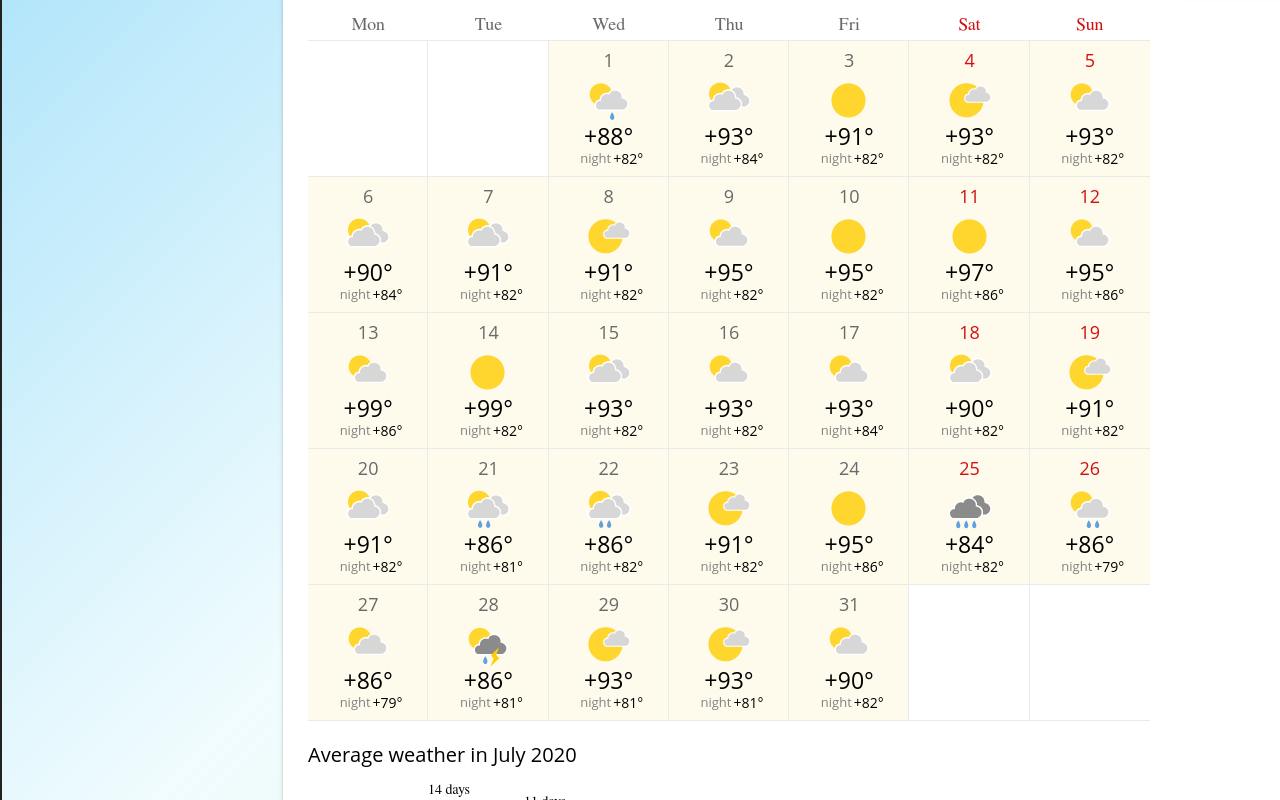